# Mapping new scRNAseq data to the Pan-Gastrointestinal atlas

### This notebook can be used as a guide for how to map new scRNAseq data to the Pan-GI atlas (from Oliver et al. Nature 2024) using scANVI

__Author:__ Amanda Oliver

__Date:__ 05/10/2024

### The atlas and relevant models can be downloaded at [gutcellatlas.org](https://gutcellatlas.org), on the Pan-GI atlas subpage

#### Annotations are predicted on a two-step basis:
1. Broad level annotation (level_1_annot) which will predict the cell lineage in order to split the object
2. Fine grained annotations (level_3_annot) which is the downstream, final level of annotation based on lineage/age/GI region

#### First some context of how the atlas was designed/annotated:
In order to make the most detailed and robust annotations possible, we split the atlas by lineage (and in some cases by age and GI region). Splitting by lineage allowed us to better distinguish cellular subtypes, especially for difficult to annotate cell states like specific T cell subsets. Since our our reference atlas included regions from the whole GI tract it was necessary to split epithelial cells by region due to their specialised nature across different regions. Similarly, since we included data from embryo/fetal samples we split mesenchymal and intestinal epithelial cells by age since these lineages are quite distinct in development and these lineages formed a large portion of the developing gut data. It is also worth noting that we kept doublets in our fine grained annotation models in order to detect additional doublets (for example, within cell type doublets which are difficult to detect). In total, there are 18 possible reference sub-atlases, here is a visual representation:
<div>
<center>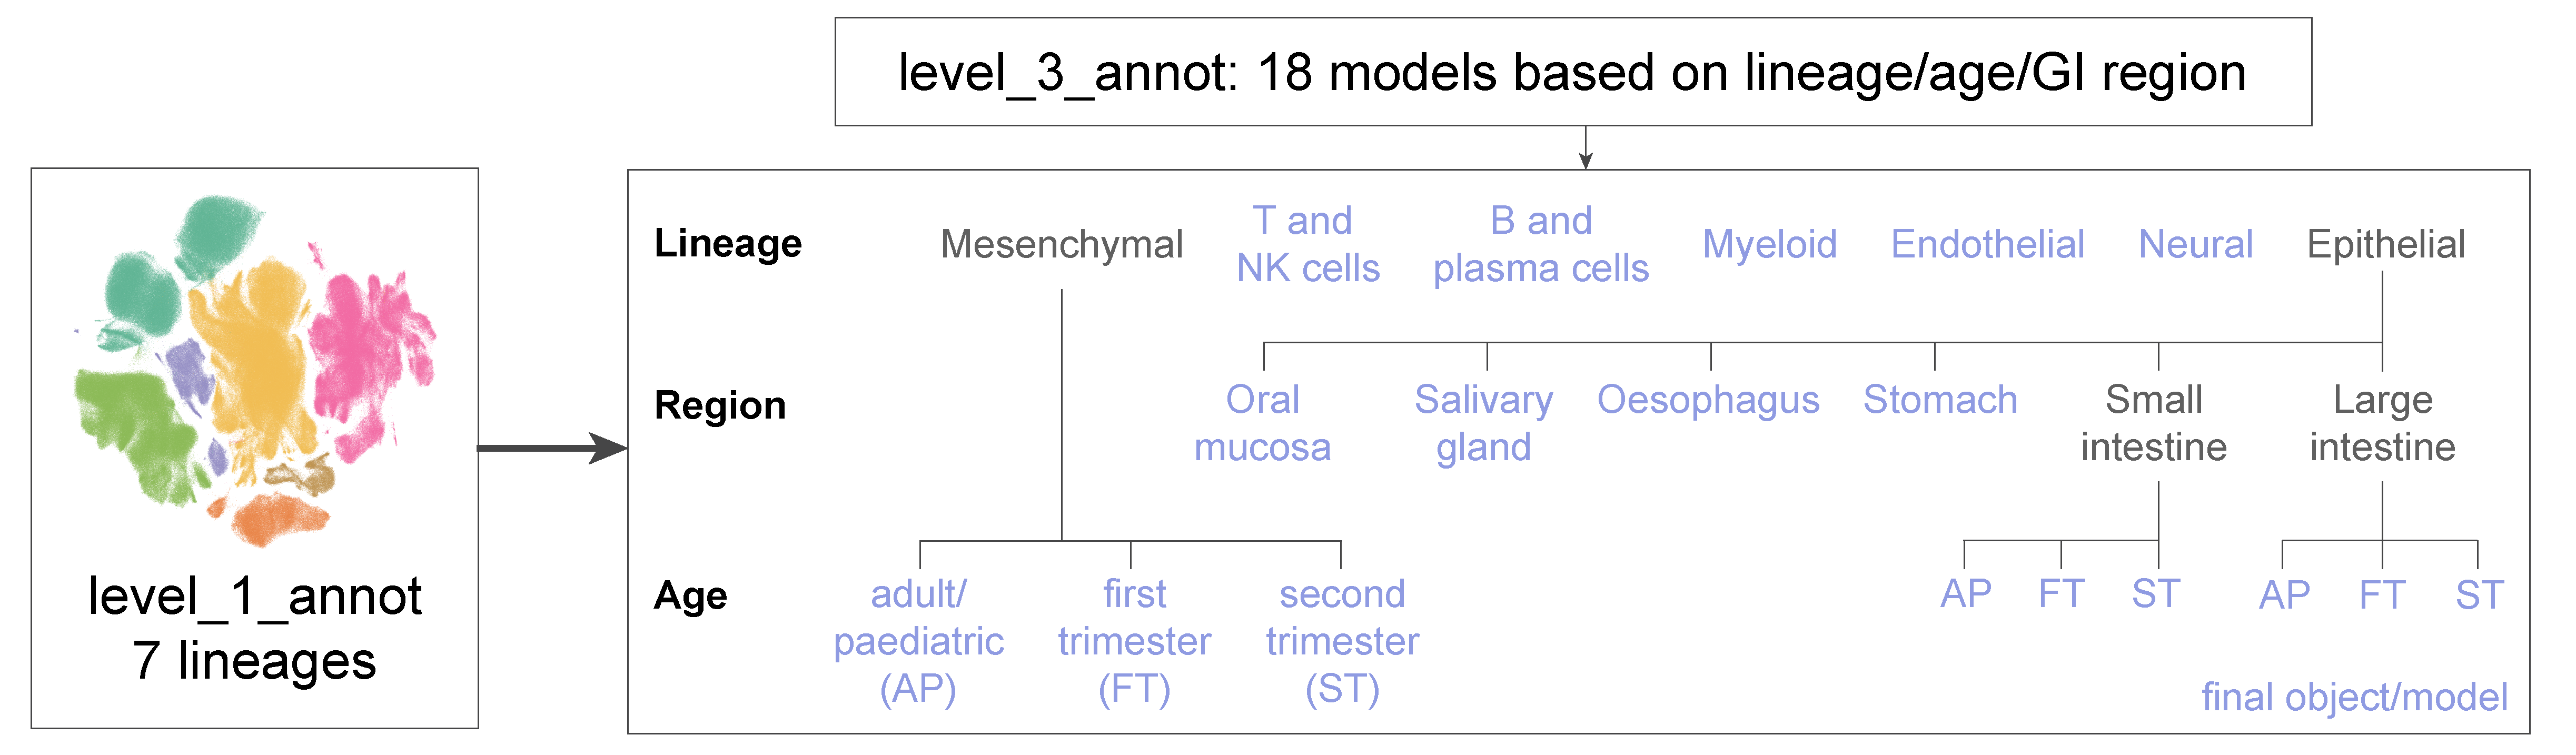
</div>

In addition to these, we also added neutrophils post atlas construction (see Supplmentary Figure 5 and related text in the paper for details) and made additional models for broad annotation and fine annotation of myeloid cells based on these (see also comments in related code below).
    
#### So, applying the above to your own atlas:
The above context is important to identify the correct reference atlases for your data. Does your dataset have multiple lineages? What is the GI region(s) of your dataset? What age(s) are sampled? These all need to be taken into account in order to identify the appropriate fine grained annotation reference (step 2 above).
    
#### Let's use an example:
In the following notebook, we'll use an example dataset from Martin et al. Cell 2019 where small intestines of CD patients were sampled, with no cell subset selection before sequencing. Therefore, we expect all lineages to be present and only interested in models from adult/pediatric small intestinal samples. For a visual representation let's put a cross through the models from the Pan-GI reference atlases that are not applicable for this study:
  
<div>
<center>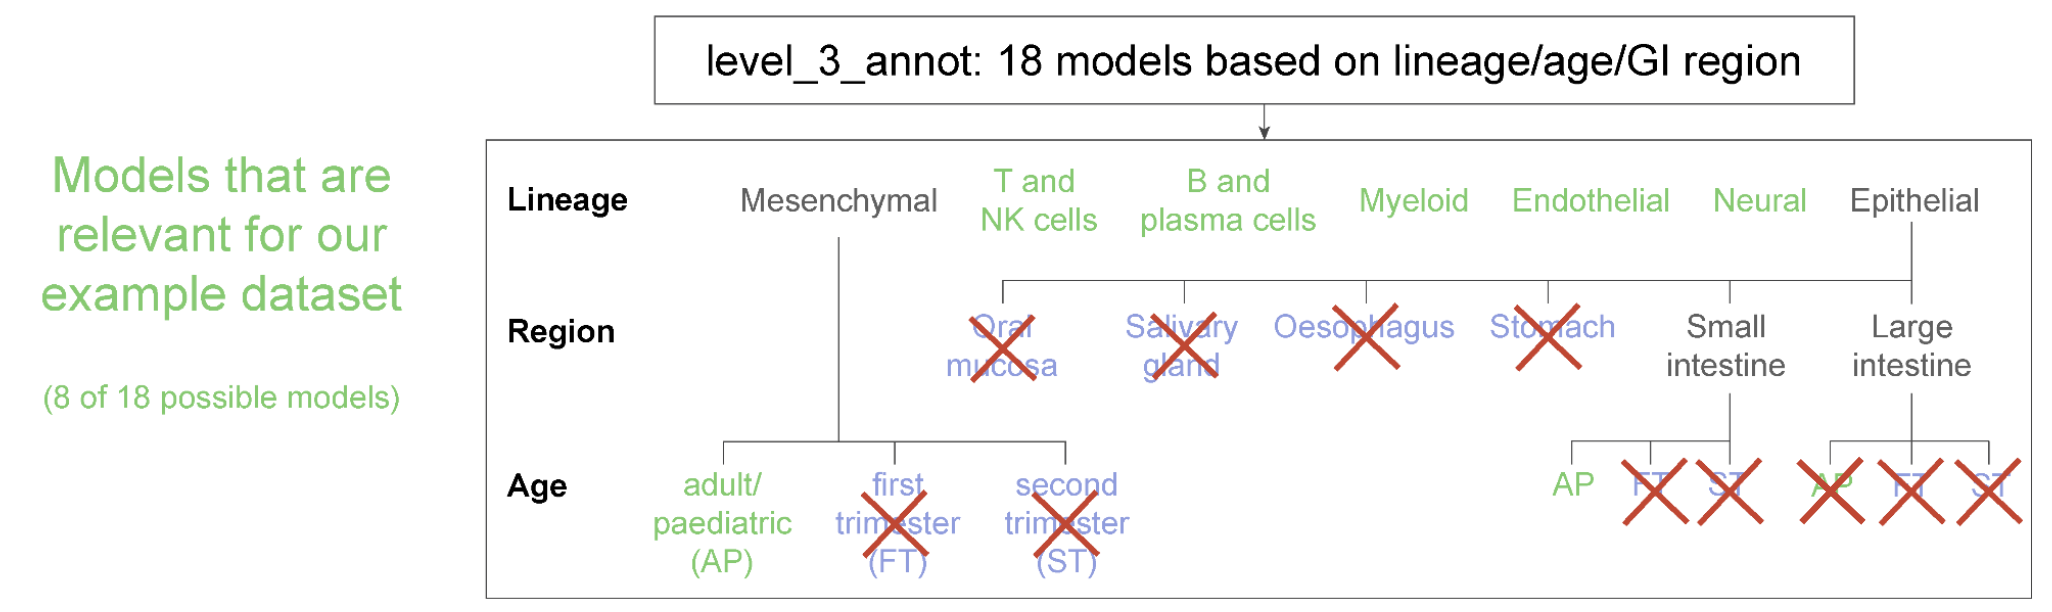</center>
</div> 
    
__Limitations of the atlas:__
The atlas construction was guided by the available data when making it, therefore we have not tested the atlas on data from non-10X scRNAseq methods or on single nuclei data. While it is still likely to gain additional insights by contextualising these types of datasets with the Pan-GI atlas, there may be certain batch effects that have not been controlled for in the original atlas.

## Import and settings

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import pickle
from sklearn.neighbors import KNeighborsTransformer
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.8.1 pandas==1.4.2 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [2]:
import scvi
print(scvi.__version__)

Global seed set to 0


0.16.4


## Define functions

In [3]:
#weighted knn trainer used to predict cell annotation based on nearest neighbour instead of (or in addition to) the built in function from scANVI
#the code comes from the HLCA: https://github.com/LungCellAtlas/HLCA_reproducibility/blob/main/scripts/label_transfer.py
def weighted_knn_trainer(train_adata, train_adata_emb, label_key, n_neighbors=50):
    """Trains a weighted KNN classifier on ``train_adata``.
    Parameters
    ----------
    train_adata: :class:`~anndata.AnnData`
        Annotated dataset to be used to train KNN classifier with ``label_key`` as the target variable.
    train_adata_emb: str
        Name of the obsm layer to be used for calculation of neighbors. If set to "X", anndata.X will be
        used
    label_key: str
        Name of the column to be used as target variable (e.g. cell_type) in ``train_adata`` and ``query_adata``.
    n_neighbors: int
        Number of nearest neighbors in KNN classifier.
    """
    print(
        f"Weighted KNN with n_neighbors = {n_neighbors} ... ",
        end="",
    )
    k_neighbors_transformer = KNeighborsTransformer(
        n_neighbors=n_neighbors,
        mode="distance",
        algorithm="brute",
        metric="euclidean",
        n_jobs=-1,
    )
    if train_adata_emb == "X":
        train_emb = train_adata.X
    elif train_adata_emb in train_adata.obsm.keys():
        train_emb = train_adata.obsm[train_adata_emb]
    else:
        raise ValueError(
            "train_adata_emb should be set to either 'X' or the name of the obsm layer to be used!"
        )
    k_neighbors_transformer.fit(train_emb)
    return k_neighbors_transformer

def weighted_knn_transfer(
    query_adata,
    query_adata_emb,
    ref_adata_obs,
    label_keys,
    knn_model,
    threshold=1,
    pred_unknown=False,
    mode="package",
):
    """Annotates ``query_adata`` cells with an input trained weighted KNN classifier.
    Parameters
    ----------
    query_adata: :class:`~anndata.AnnData`
        Annotated dataset to be used to queryate KNN classifier. Embedding to be used
    query_adata_emb: str
        Name of the obsm layer to be used for label transfer. If set to "X",
        query_adata.X will be used
    ref_adata_obs: :class:`pd.DataFrame`
        obs of ref Anndata
    label_keys: str
        Names of the columns to be used as target variables (e.g. cell_type) in ``query_adata``.
    knn_model: :class:`~sklearn.neighbors._graph.KNeighborsTransformer`
        knn model trained on reference adata with weighted_knn_trainer function
    threshold: float
        Threshold of uncertainty used to annotating cells as "Unknown". cells with
        uncertainties higher than this value will be annotated as "Unknown".
        Set to 1 to keep all predictions. This enables one to later on play
        with thresholds.
    pred_unknown: bool
        ``False`` by default. Whether to annotate any cell as "unknown" or not.
        If `False`, ``threshold`` will not be used and each cell will be annotated
        with the label which is the most common in its ``n_neighbors`` nearest cells.
    mode: str
        Has to be one of "paper" or "package". If mode is set to "package",
        uncertainties will be 1 - P(pred_label), otherwise it will be 1 - P(true_label).
    """
    if not type(knn_model) == KNeighborsTransformer:
        raise ValueError(
            "knn_model should be of type sklearn.neighbors._graph.KNeighborsTransformer!"
        )

    if query_adata_emb == "X":
        query_emb = query_adata.X
    elif query_adata_emb in query_adata.obsm.keys():
        query_emb = query_adata.obsm[query_adata_emb]
    else:
        raise ValueError(
            "query_adata_emb should be set to either 'X' or the name of the obsm layer to be used!"
        )
    top_k_distances, top_k_indices = k_neighbors_transformer.kneighbors(X=query_emb)

    stds = np.std(top_k_distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)

    top_k_distances_tilda = np.exp(-np.true_divide(top_k_distances, stds))

    weights = top_k_distances_tilda / np.sum(
        top_k_distances_tilda, axis=1, keepdims=True
    )
    cols = ref_adata_obs.columns[ref_adata_obs.columns.str.startswith(label_keys)]
    uncertainties = pd.DataFrame(columns=cols, index=query_adata.obs_names)
    pred_labels = pd.DataFrame(columns=cols, index=query_adata.obs_names)
    for i in range(len(weights)):
        for j in cols:
            y_train_labels = ref_adata_obs[j].values
            unique_labels = np.unique(y_train_labels[top_k_indices[i]])
            best_label, best_prob = None, 0.0
            for candidate_label in unique_labels:
                candidate_prob = weights[
                    i, y_train_labels[top_k_indices[i]] == candidate_label
                ].sum()
                if best_prob < candidate_prob:
                    best_prob = candidate_prob
                    best_label = candidate_label

            if pred_unknown:
                if best_prob >= threshold:
                    pred_label = best_label
                else:
                    pred_label = "Unknown"
            else:
                pred_label = best_label

            if mode == "package":
                uncertainties.iloc[i][j] = (max(1 - best_prob, 0))

            else:
                raise Exception("Inquery Mode!")

            pred_labels.iloc[i][j] = (pred_label)

    print("finished!")

    return pred_labels, uncertainties

## Load data

In [4]:
adata = sc.read_h5ad('/home/jupyter/Atlas_test/Martin_test.h5ad')
#make sure you reformat your patient/donor ID to conform with our models - we use the donorID as the batch key for integration
#eg. adata.obs['donorID_unified'] = adata.obs['Patient_ID'].copy()

In [5]:
adata

AnnData object with n_obs × n_vars = 10973 × 36601
    obs: 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'percent_soup', 'percent_spliced', 'sampleID', 'sourceID', 'donorID_original', 'study', 'donorID_corrected', 'donorID_unified', 'donor_category', 'donor_disease', 'organ_original', 'organ_unified', 'organ_broad', 'age_original', 'age_unified', 'age_continuousadult', 'age_continuousdev', 'sex', 'sample_type', 'sample_category', 'sample_retrieval', 'tissue_fraction', 'cell_fraction', 'cell_fraction_unified', 'cell_sorting', 'technology'
    var: 'gene_ids', 'feature_type', 'mito', 'ribo', 'hb', 'cc', 'ig', 'tcr', 'n_counts-0', 'n_counts_raw-0', 'n_counts_spliced-0', 'n_counts_unspliced-0', 'n_cells-0', 'n_cells_raw-0', 'n_cells_spliced-0', 'n_cells_unspliced-0', 'n_counts-1', 'n_counts_raw-1', 'n_counts_spliced-1', 'n_counts_unspliced-1', 'n_cells-1', 'n_cells_r

In [6]:
#save copy for later
adata_copy = adata.copy()

### Set directories

In [7]:
scanvi_models_path = '/home/jupyter/Atlas_test/models/scANVI_models/' 
knn_models_path = '/home/jupyter/Atlas_test/models/kNN_models/'
output_dir = "/home/jupyter/Atlas_test/output/"

# Broad (level 1) annotation prediction
- Alternatively you can also annotate broad lineages manually, as long as the output is 7 final lineages to fit with the downstream models (mentioned above in the preamble)
- scANVI is quite intensive, depending on resources this is better adapted as a script but for ease of demonstration I am running this on GPU notebook

### Run scANVI

In [8]:
#run scANVI with relevant reference, in this case we are using the broad annotation reference
scanvi_query = scvi.model.SCANVI.load_query_data(
    adata,
    scanvi_models_path+"Broad_annot_20220817.scanvi_model", 
    #or Broad_annot_withNeutrophils_20240131.scanvi_model if you think your dataset has neutrophils
    inplace_subset_query_vars = True
)
scanvi_query.train(
    max_epochs=100, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10
)

INFO     File /home/jupyter/Atlas_test/models/scANVI_models/Broad_annot_20220817.scanvi_model
         /model.pt already downloaded                                                        
INFO     Training for 100 epochs.                                                            


/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_scanvi.py:89: UserWarning: Missing labels key broad_annot_20220917. Filling in with unlabeled category Unknown.
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
     

Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:61: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/jupyter/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 100/100: 100%|██████████| 100/100 [02:09<00:00,  1.29s/it, loss=493, v_num=1]


In [9]:
#get latent coordinates
adata.obsm["X_scANVI"] = scanvi_query.get_latent_representation()

#if desired, save latent coordinates as dataframe eg.
#pd.DataFrame(
#    adata.obsm["X_scANVI"],
#    index=adata.obs_names,
#    columns=[f"LV{i+1}" for i in range(adata.obsm["X_scANVI"].shape[1])],
#).to_csv(
#    "/path/scANVI_obsm.csv"
#)

### Predict cell types using knn model

In [10]:
#load k_neighbors_transformer
with open(knn_models_path+'kNN_healthy_reference_broad_annot_model.pkl', 'rb') as f:
    k_neighbors_transformer = pickle.load(f)
#or knn_label_transfer_model_healthy_reference_broad_annot_withNeutrophils_20241005.pkl

In [11]:
ref_obs = pd.read_csv(knn_models_path+'obs/health_reference_broad_annot_obs.csv') #or health_reference_broad_annot_obs.csv

In [12]:
#run label prediction based on weighted knn classifier
labels, uncert = weighted_knn_transfer(
        query_adata=adata,
        query_adata_emb="X_scANVI",
        label_keys="broad_annot_20220917",
        knn_model=k_neighbors_transformer,
        ref_adata_obs = ref_obs
    )

adata.obs['predicted_level_1_annot'] = labels['broad_annot_20220917']
adata.obs['predicted_level_1_annot_uncertainty'] = uncert['broad_annot_20220917']

/opt/conda/envs/scvi/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsTransformer was fitted with feature names
  warnings.warn(


finished!


In [13]:
#if you wish, also run inbuilt scANVI cell type prediction
adata.obs["predicted_level_1_annot_scanvi"] = scanvi_query.predict(adata)

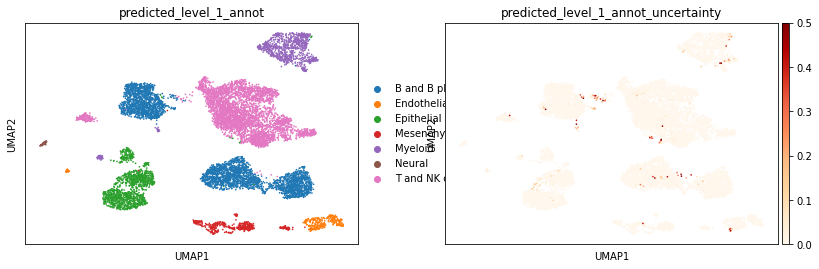

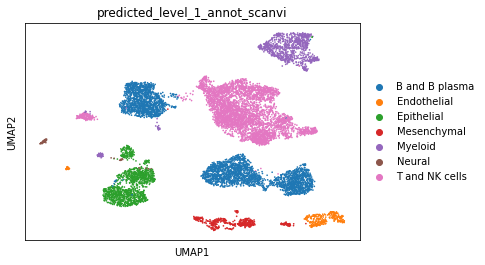

In [14]:
#now lets visualise the data
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)
sc.pl.umap(adata, color=['predicted_level_1_annot','predicted_level_1_annot_uncertainty'], color_map="OrRd")
sc.pl.umap(adata, color=['predicted_level_1_annot_scanvi'], color_map="OrRd")

Above you can see that the knn based and scanvi predictions agree quite well. For broad annotations there is low uncertainty (ie. the predictions come with a high level of certainty).

#### Check broad annotations

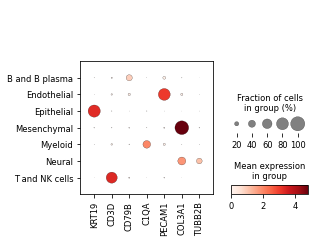

In [15]:
#save raw counts
adata.raw = adata.copy()
#normalise and log transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
#plot list of non-exhaustive marker genes within model
sc.pl.dotplot(adata, var_names = ["KRT19", #epithelial cells
                                  "CD3D", #T cells
                                  "CD79B", #B cells
                                  "C1QA", #myeloid cells
                                  "PECAM1", #endothelial cells
                                  "COL3A1", #mesenchymal cells
                                  "TUBB2B", #neural cells
                                 ], groupby='predicted_level_1_annot', use_raw=False)

In [16]:
adata

AnnData object with n_obs × n_vars = 10973 × 7280
    obs: 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'percent_soup', 'percent_spliced', 'sampleID', 'sourceID', 'donorID_original', 'study', 'donorID_corrected', 'donorID_unified', 'donor_category', 'donor_disease', 'organ_original', 'organ_unified', 'organ_broad', 'age_original', 'age_unified', 'age_continuousadult', 'age_continuousdev', 'sex', 'sample_type', 'sample_category', 'sample_retrieval', 'tissue_fraction', 'cell_fraction', 'cell_fraction_unified', 'cell_sorting', 'technology', '_scvi_batch', 'broad_annot_20220917', '_scvi_labels', 'predicted_level_1_annot', 'predicted_level_1_annot_uncertainty', 'predicted_level_1_annot_scanvi'
    var: 'gene_ids', 'feature_type', 'mito', 'ribo', 'hb', 'cc', 'ig', 'tcr', 'n_counts-0', 'n_counts_raw-0', 'n_counts_spliced-0', 'n_counts_unspliced-0', 'n_cells-0', 'n_cells

# Fine grained (level 3) annotation prediction

In [17]:
#recover adata_copy with new obsm and obs to retain full gene expression
adata_copy.obsm = adata.obsm
adata_copy.obs = adata.obs

In [18]:
#subset lineages
b = adata_copy[adata_copy.obs['predicted_level_1_annot'] == "B and B plasma"].copy()
endo = adata_copy[adata_copy.obs['predicted_level_1_annot'] == "Endothelial"].copy()
mes = adata_copy[adata_copy.obs['predicted_level_1_annot'] == "Mesenchymal"].copy()
mye = adata_copy[adata_copy.obs['predicted_level_1_annot'] == "Myeloid"].copy()
neural = adata_copy[adata_copy.obs['predicted_level_1_annot'] == "Neural"].copy()
tnk = adata_copy[adata_copy.obs['predicted_level_1_annot'] == "T and NK cells"].copy()
epi = adata_copy[adata_copy.obs['predicted_level_1_annot'] == "Epithelial"].copy()
#as discussed above, this dataset has samples from the small intestine only
#however, if you had multiple regions (eg. small and large intestine) you would need to subset further, for example:
#epiSI = epi[epi.obs['region'] != "large_intestine"].copy()
#epiLI = epi[epi.obs['region'] = "large_intestine"].copy()
#the same concept applies if you had data from adult/pediatric and embryonic/fetal gut samples in the same dataset

## B cells

INFO     File                                                                                
         /home/jupyter/Atlas_test/models/scANVI_models/B_scanvi_fine_annot.20230226/model.pt 
         already downloaded                                                                  
INFO     Training for 100 epochs.                                                            


/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_scanvi.py:89: UserWarning: Missing labels key fine_annot. Filling in with unlabeled category Unknown.
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
               

Epoch 100/100: 100%|██████████| 100/100 [00:40<00:00,  2.45it/s, loss=322, v_num=1]
finished!


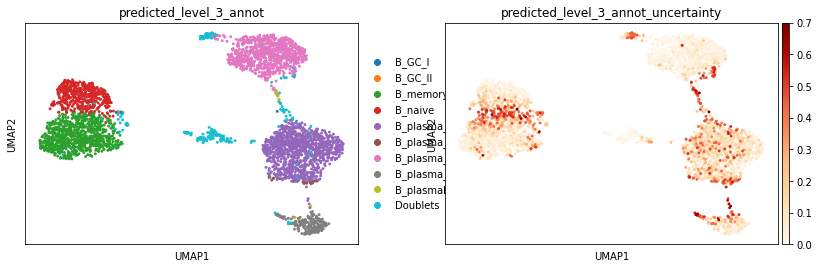

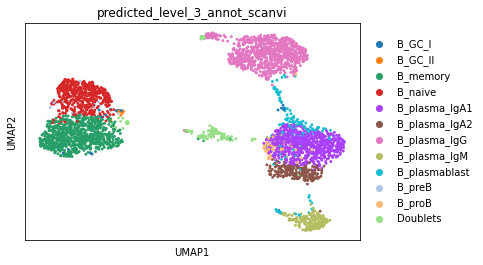

In [19]:
subset = b.copy()
subset_name = "Bcells"
scanvi_model = "B_scanvi_fine_annot.20230226"
knn_model = "knn_label_transfer_model_healthy_reference_B_20230226.pkl"
ref_obs_path = "/home/jupyter/Annotations_v3/meta/obs_for_knn/"

#set subset as bdata
bdata = subset.copy()

#run scANVI
scanvi_query = scvi.model.SCANVI.load_query_data(
    bdata,
    scanvi_models_path+scanvi_model, 
    inplace_subset_query_vars = True
)
scanvi_query.train(
    max_epochs=100, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10
)
bdata.obsm["X_scANVI"] = scanvi_query.get_latent_representation()
#if desired, save latent coordinates as dataframe eg.
#pd.DataFrame(
#    adata.obsm["X_scANVI"],
#    index=adata.obs_names,
#    columns=[f"LV{i+1}" for i in range(disease_ad.obsm["X_scANVI"].shape[1])],
#).to_csv(
#    "/path/scANVI_obsm.csv"
#)


#load k_neighbors_transformer
with open(knn_models_path+knn_model, 'rb') as f:
    k_neighbors_transformer = pickle.load(f)

#load reference obs
ref_obs = pd.read_csv(knn_models_path+'obs/'+subset_name+'_obs.csv')
    
#run KNN
labels, uncert = weighted_knn_transfer(
        query_adata=bdata,
        query_adata_emb="X_scANVI",
        label_keys="fine_annot",
        knn_model=k_neighbors_transformer,
        ref_adata_obs = ref_obs
    )

#weighted knn transfer prediction
bdata.obs['predicted_level_3_annot'] = labels['fine_annot']
bdata.obs['predicted_level_3_annot_uncertainty'] = uncert['fine_annot']
#scanvi prediction
bdata.obs["predicted_level_3_annot_scanvi"] = scanvi_query.predict(bdata)

#now lets visualise the data
sc.pp.neighbors(bdata, use_rep="X_scANVI")
sc.tl.umap(bdata)
sc.pl.umap(bdata, color=['predicted_level_3_annot','predicted_level_3_annot_uncertainty'], color_map="OrRd")
sc.pl.umap(bdata, color=['predicted_level_3_annot_scanvi'], color_map="OrRd")

#save object
subset.obs['predicted_level_3_annot'] = bdata.obs['predicted_level_3_annot']
subset.obs['predicted_level_3_annot_scanvi'] = bdata.obs['predicted_level_3_annot_scanvi']
subset.obs['predicted_level_1_annot_uncertainty'] = bdata.obs['predicted_level_1_annot_uncertainty'].astype(float)
subset.obs['predicted_level_3_annot_uncertainty'] = bdata.obs['predicted_level_3_annot_uncertainty'].astype(float)
subset.write("/home/jupyter/Atlas_test/output/"+subset_name+"_level_3_annotations.h5ad")
#and/or save metadata and latent coordinates
#pd.DataFrame(
#    bdata.obsm["X_scANVI"],
#    index=bdata.obs_names,
#    columns=[f"LV{i+1}" for i in range(bdata.obsm["X_scANVI"].shape[1])],
#).to_csv(
#    "/path/scANVI_obsm.csv"
#)
obs_to_save = bdata.obs[['predicted_level_3_annot','predicted_level_3_annot_uncertainty','predicted_level_3_annot_scanvi']]
obs_to_save.to_csv('/home/jupyter/Atlas_test/output/'+subset_name+'level_3_pred.csv')

In [20]:
bdata

AnnData object with n_obs × n_vars = 3623 × 4397
    obs: 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'percent_soup', 'percent_spliced', 'sampleID', 'sourceID', 'donorID_original', 'study', 'donorID_corrected', 'donorID_unified', 'donor_category', 'donor_disease', 'organ_original', 'organ_unified', 'organ_broad', 'age_original', 'age_unified', 'age_continuousadult', 'age_continuousdev', 'sex', 'sample_type', 'sample_category', 'sample_retrieval', 'tissue_fraction', 'cell_fraction', 'cell_fraction_unified', 'cell_sorting', 'technology', '_scvi_batch', 'broad_annot_20220917', '_scvi_labels', 'predicted_level_1_annot', 'predicted_level_1_annot_uncertainty', 'predicted_level_1_annot_scanvi', 'fine_annot', 'predicted_level_3_annot', 'predicted_level_3_annot_uncertainty', 'predicted_level_3_annot_scanvi'
    var: 'gene_ids', 'feature_type', 'mito', 'ribo', 'hb', 'cc',

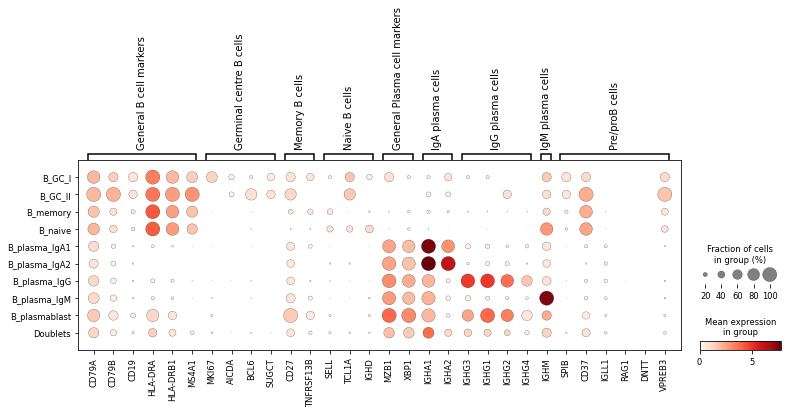

In [21]:
#cross reference marker genes
marker_genes_dict = {'General B cell markers':['CD79A','CD79B','CD19','HLA-DRA','HLA-DRB1','MS4A1'],
                     'Germinal centre B cells':['MKI67','AICDA','BCL6','SUGCT'],
                    'Memory B cells':['CD27','TNFRSF13B'],
                     'Naive B cells':['SELL','TCL1A','IGHD'],
                     'General Plasma cell markers':['MZB1','XBP1'],
                     'IgA plasma cells':['IGHA1','IGHA2'],
                     'IgG plasma cells':['IGHG3','IGHG1','IGHG2','IGHG4'],
                     'IgM plasma cells':['IGHM'],
                     'Pre/proB cells':['SPIB','CD37','IGLL1','RAG1','DNTT','VPREB3']}
sc.pp.normalize_total(subset, target_sum=1e4)
sc.pp.log1p(subset)
sc.pl.dotplot(subset,var_names=marker_genes_dict,groupby='predicted_level_3_annot',use_raw=False)

Now repeat for the remaining subsets!

## Endothelial cells

INFO     File /home/jupyter/Atlas_test/models/scANVI_models/Endo_scanvi_fine_annot.20230226/m
         odel.pt already downloaded                                                          
INFO     Training for 100 epochs.                                                            


/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/data/_utils.py:156: UserWarning: Category 39 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_scanvi.py:89: UserWarning: Missing labels key fine_annot. Filling in with unlabeled category Unknown.
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
            

Epoch 100/100: 100%|██████████| 100/100 [00:05<00:00, 18.85it/s, loss=981, v_num=1]   
finished!


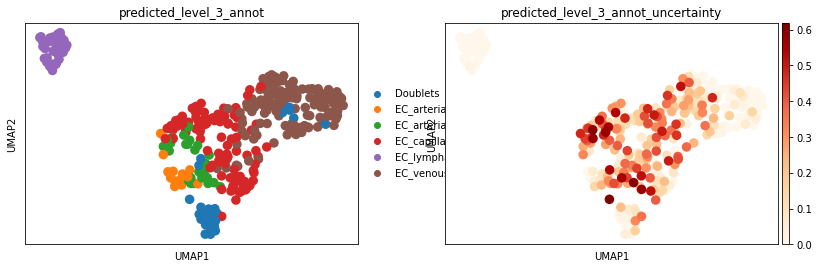

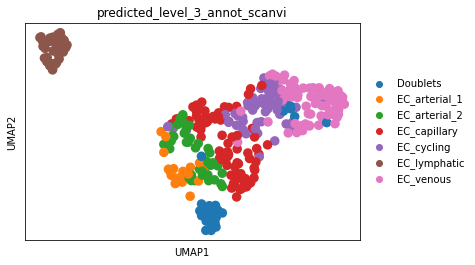

In [22]:
subset = endo.copy()
subset_name = "Endo"
scanvi_model = "Endo_scanvi_fine_annot.20230226"
knn_model = "knn_label_transfer_model_healthy_reference_Endo_20230226.pkl"
ref_obs_path = "/home/jupyter/Annotations_v3/meta/obs_for_knn/"

#set subset as bdata
bdata = subset.copy()

#run scANVI
scanvi_query = scvi.model.SCANVI.load_query_data(
    bdata,
    scanvi_models_path+scanvi_model, 
    inplace_subset_query_vars = True
)
scanvi_query.train(
    max_epochs=100, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10
)
bdata.obsm["X_scANVI"] = scanvi_query.get_latent_representation()
#if desired, save latent coordinates as dataframe eg.
#pd.DataFrame(
#    adata.obsm["X_scANVI"],
#    index=adata.obs_names,
#    columns=[f"LV{i+1}" for i in range(disease_ad.obsm["X_scANVI"].shape[1])],
#).to_csv(
#    "/path/scANVI_obsm.csv"
#)


#load k_neighbors_transformer
with open(knn_models_path+knn_model, 'rb') as f:
    k_neighbors_transformer = pickle.load(f)

#load reference obs
ref_obs = pd.read_csv(knn_models_path+'obs/'+subset_name+'_obs.csv')
    
#run KNN
labels, uncert = weighted_knn_transfer(
        query_adata=bdata,
        query_adata_emb="X_scANVI",
        label_keys="fine_annot",
        knn_model=k_neighbors_transformer,
        ref_adata_obs = ref_obs
    )

#weighted knn transfer prediction
bdata.obs['predicted_level_3_annot'] = labels['fine_annot']
bdata.obs['predicted_level_3_annot_uncertainty'] = uncert['fine_annot']
#scanvi prediction
bdata.obs["predicted_level_3_annot_scanvi"] = scanvi_query.predict(bdata)

#now lets visualise the data
sc.pp.neighbors(bdata, use_rep="X_scANVI")
sc.tl.umap(bdata)
sc.pl.umap(bdata, color=['predicted_level_3_annot','predicted_level_3_annot_uncertainty'], color_map="OrRd")
sc.pl.umap(bdata, color=['predicted_level_3_annot_scanvi'], color_map="OrRd")

#save object
subset.obs['predicted_level_3_annot'] = bdata.obs['predicted_level_3_annot']
subset.obs['predicted_level_3_annot_scanvi'] = bdata.obs['predicted_level_3_annot_scanvi']
subset.obs['predicted_level_1_annot_uncertainty'] = bdata.obs['predicted_level_1_annot_uncertainty'].astype(float)
subset.obs['predicted_level_3_annot_uncertainty'] = bdata.obs['predicted_level_3_annot_uncertainty'].astype(float)
subset.write("/home/jupyter/Atlas_test/output/"+subset_name+"_level_3_annotations.h5ad")
#and/or save metadata and latent coordinates
#pd.DataFrame(
#    bdata.obsm["X_scANVI"],
#    index=bdata.obs_names,
#    columns=[f"LV{i+1}" for i in range(bdata.obsm["X_scANVI"].shape[1])],
#).to_csv(
#    "/path/scANVI_obsm.csv"
#)
obs_to_save = bdata.obs[['predicted_level_3_annot','predicted_level_3_annot_uncertainty','predicted_level_3_annot_scanvi']]
obs_to_save.to_csv('/home/jupyter/Atlas_test/output/'+subset_name+'level_3_pred.csv')

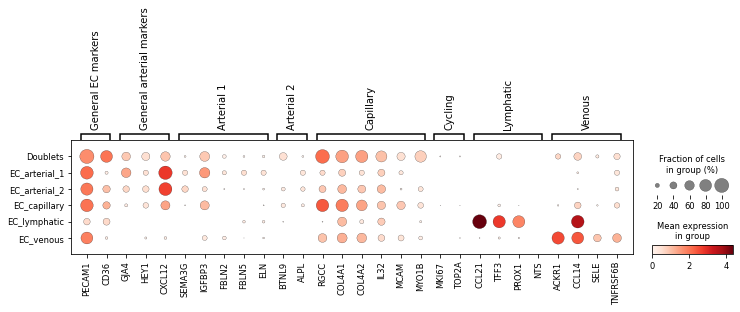

In [23]:
#cross reference marker genes
marker_genes_dict = {'General EC markers':['PECAM1','CD36'],
                     'General arterial markers':['GJA4','HEY1','CXCL12'],
                     'Arterial 1':['SEMA3G','IGFBP3','FBLN2','FBLN5','ELN'],
                     'Arterial 2':['BTNL9','ALPL'],
                     'Capillary':['RGCC','COL4A1','COL4A2','IL32','MCAM','MYO1B'],
                     'Cycling':['MKI67','TOP2A'],
                     'Lymphatic':['CCL21','TFF3','PROX1','NTS'],
                     'Venous':['ACKR1','CCL14','SELE','TNFRSF6B']
                    }
sc.pp.normalize_total(subset, target_sum=1e4)
sc.pp.log1p(subset)
sc.pl.dotplot(subset,var_names=marker_genes_dict,groupby='predicted_level_3_annot',use_raw=False)

## Mesenchymal cells

INFO     File /home/jupyter/Atlas_test/models/scANVI_models/Mes_AP_scanvi_fine_annot.20230226
         /model.pt already downloaded                                                        
INFO     Training for 100 epochs.                                                            


/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_scanvi.py:89: UserWarning: Missing labels key fine_annot. Filling in with unlabeled category Unknown.
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
               

Epoch 100/100: 100%|██████████| 100/100 [00:06<00:00, 14.73it/s, loss=1.01e+03, v_num=1]
finished!


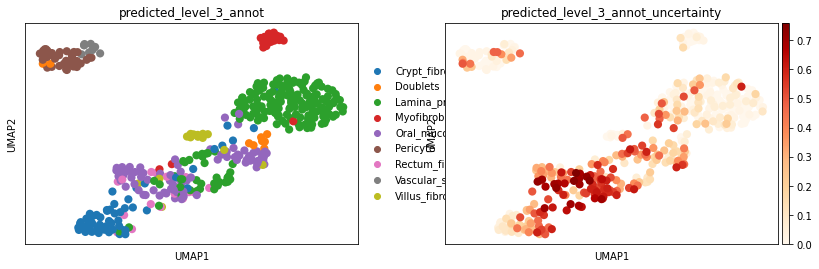

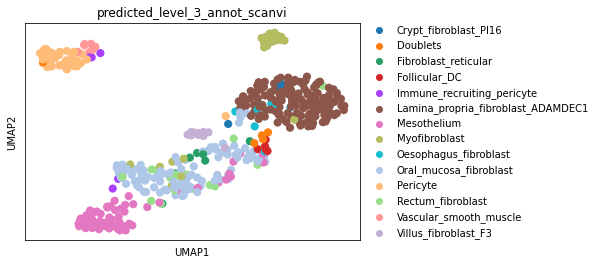

In [24]:
subset = mes
subset_name = "Mes_AP"
scanvi_model = "Mes_AP_scanvi_fine_annot.20230226"
knn_model = "knn_label_transfer_model_healthy_reference_Mes_20230226.pkl"
ref_obs_path = "/home/jupyter/Annotations_v3/meta/obs_for_knn/"

#set subset as bdata
bdata = subset.copy()

#run scANVI
scanvi_query = scvi.model.SCANVI.load_query_data(
    bdata,
    scanvi_models_path+scanvi_model, 
    inplace_subset_query_vars = True
)
scanvi_query.train(
    max_epochs=100, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10
)
bdata.obsm["X_scANVI"] = scanvi_query.get_latent_representation()
#if desired, save latent coordinates as dataframe eg.
#pd.DataFrame(
#    adata.obsm["X_scANVI"],
#    index=adata.obs_names,
#    columns=[f"LV{i+1}" for i in range(disease_ad.obsm["X_scANVI"].shape[1])],
#).to_csv(
#    "/path/scANVI_obsm.csv"
#)


#load k_neighbors_transformer
with open(knn_models_path+knn_model, 'rb') as f:
    k_neighbors_transformer = pickle.load(f)

#load reference obs
ref_obs = pd.read_csv(knn_models_path+'obs/'+subset_name+'_obs.csv')
    
#run KNN
labels, uncert = weighted_knn_transfer(
        query_adata=bdata,
        query_adata_emb="X_scANVI",
        label_keys="fine_annot",
        knn_model=k_neighbors_transformer,
        ref_adata_obs = ref_obs
    )

#weighted knn transfer prediction
bdata.obs['predicted_level_3_annot'] = labels['fine_annot']
bdata.obs['predicted_level_3_annot_uncertainty'] = uncert['fine_annot']
#scanvi prediction
bdata.obs["predicted_level_3_annot_scanvi"] = scanvi_query.predict(bdata)

#now lets visualise the data
sc.pp.neighbors(bdata, use_rep="X_scANVI")
sc.tl.umap(bdata)
sc.pl.umap(bdata, color=['predicted_level_3_annot','predicted_level_3_annot_uncertainty'], color_map="OrRd")
sc.pl.umap(bdata, color=['predicted_level_3_annot_scanvi'], color_map="OrRd")

#save object
subset.obs['predicted_level_3_annot'] = bdata.obs['predicted_level_3_annot']
subset.obs['predicted_level_3_annot_scanvi'] = bdata.obs['predicted_level_3_annot_scanvi']
subset.obs['predicted_level_1_annot_uncertainty'] = bdata.obs['predicted_level_1_annot_uncertainty'].astype(float)
subset.obs['predicted_level_3_annot_uncertainty'] = bdata.obs['predicted_level_3_annot_uncertainty'].astype(float)
subset.write("/home/jupyter/Atlas_test/output/"+subset_name+"_level_3_annotations.h5ad")
#and/or save metadata and latent coordinates
#pd.DataFrame(
#    bdata.obsm["X_scANVI"],
#    index=bdata.obs_names,
#    columns=[f"LV{i+1}" for i in range(bdata.obsm["X_scANVI"].shape[1])],
#).to_csv(
#    "/path/scANVI_obsm.csv"
#)
obs_to_save = bdata.obs[['predicted_level_3_annot','predicted_level_3_annot_uncertainty','predicted_level_3_annot_scanvi']]
obs_to_save.to_csv('/home/jupyter/Atlas_test/output/'+subset_name+'level_3_pred.csv')

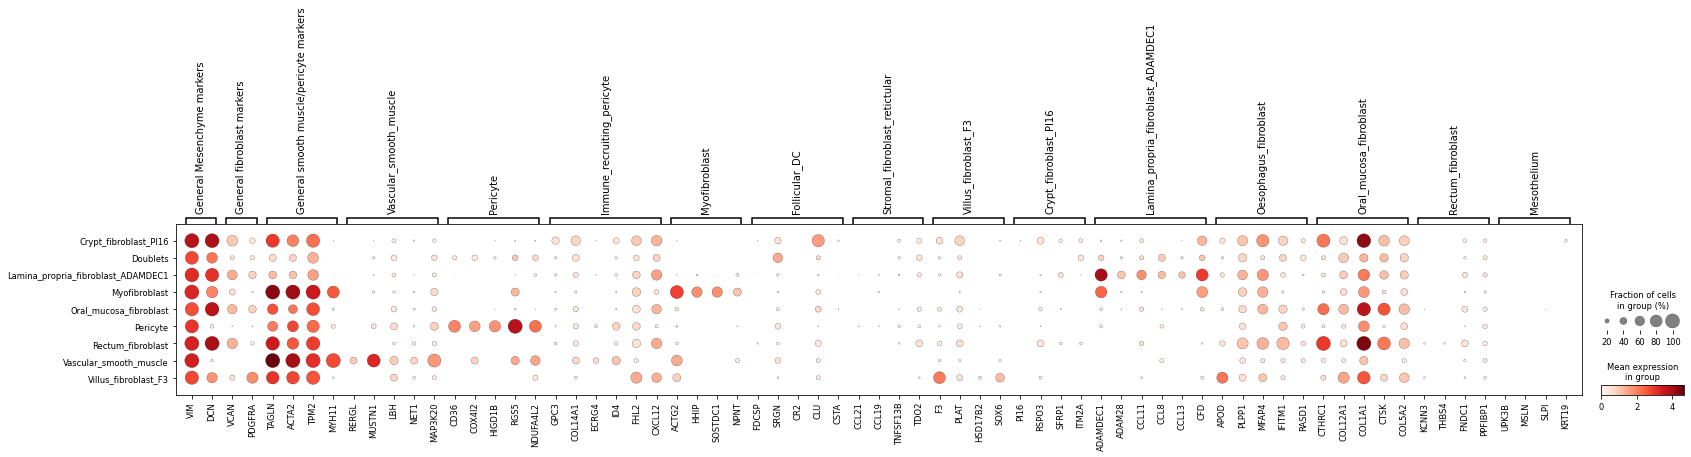

In [25]:
#cross reference marker genes
marker_genes_dict = {'General Mesenchyme markers':['VIM','DCN'],
                     'General fibroblast markers':['VCAN','PDGFRA'],
                     'General smooth muscle/pericyte markers':['TAGLN', 'ACTA2','TPM2', 'MYH11'],
                     'Vascular_smooth_muscle':['RERGL','MUSTN1','LBH','NET1','MAP3K20'],
                     'Pericyte':['CD36','COX4I2','HIGD1B','RGS5','NDUFA4L2'],
                     'Immune_recruiting_pericyte':['GPC3','COL14A1','ECRG4','ID4','FHL2','CXCL12'],
                     'Myofibroblast':['ACTG2','HHIP','SOSTDC1','NPNT'],
                     'Follicular_DC':['FDCSP','SRGN','CR2','CLU','CSTA'],
                     'Stromal_fibroblast_retictular':['CCL21','CCL19','TNFSF13B','TDO2'],
                     'Villus_fibroblast_F3':['F3','PLAT','HSD17B2','SOX6'],
                     'Crypt_fibroblast_PI16':['PI16','RSPO3','SFRP1','ITM2A'],
                     'Lamina_propria_fibroblast_ADAMDEC1':['ADAMDEC1','ADAM28','CCL11','CCL8','CCL13','CFD'],
                     'Oesophagus_fibroblast':['APOD','PLPP1','MFAP4','IFITM1','RASD1'],
                     'Oral_mucosa_fibroblast':['CTHRC1','COL12A1','COL1A1','CTSK','COL5A2'],
                     'Rectum_fibroblast':['KCNN3','THBS4','FNDC1','PPFIBP1'],
                     'Mesothelium':['UPK3B','MSLN','SLPI','KRT19']}
sc.pp.normalize_total(subset, target_sum=1e4)
sc.pp.log1p(subset)
sc.pl.dotplot(subset,var_names=marker_genes_dict,groupby='predicted_level_3_annot',use_raw=False)

## Myeloid cells

INFO     File /home/jupyter/Atlas_test/models/scANVI_models/Myeloid_scanvi_fine_annot.2023022
         6/model.pt already downloaded                                                       
INFO     Training for 100 epochs.                                                            


/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_scanvi.py:89: UserWarning: Missing labels key fine_annot. Filling in with unlabeled category Unknown.
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
               

Epoch 100/100: 100%|██████████| 100/100 [00:11<00:00,  8.41it/s, loss=687, v_num=1]
finished!


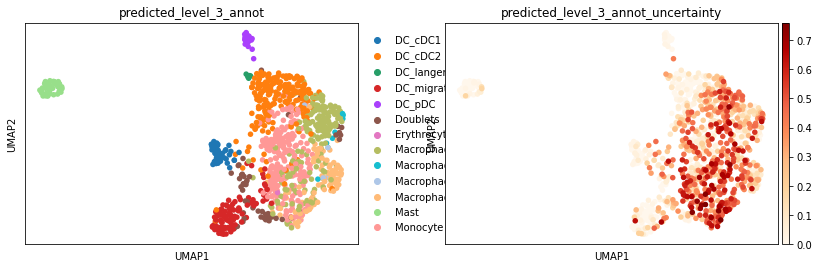

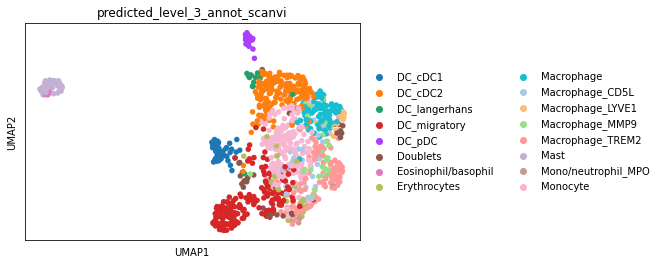

In [26]:
subset = mye
subset_name = "Myeloid" #or Myeloid_withNeutrophils
scanvi_model = "Myeloid_scanvi_fine_annot.20230226"
#or MyeloidwithNeutrophils_scanvi_fine_annot.20240131
knn_model = "knn_label_transfer_model_healthy_reference_Myeloid_20230226.pkl"
#or knn_label_transfer_model_healthy_reference_Myeloid_withNeutrophils_20241005.pkl
ref_obs_path = "/home/jupyter/Annotations_v3/meta/obs_for_knn/"

#set subset as bdata
bdata = subset.copy()

#run scANVI
scanvi_query = scvi.model.SCANVI.load_query_data(
    bdata,
    scanvi_models_path+scanvi_model, 
    inplace_subset_query_vars = True
)
scanvi_query.train(
    max_epochs=100, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10
)
bdata.obsm["X_scANVI"] = scanvi_query.get_latent_representation()
#if desired, save latent coordinates as dataframe eg.
#pd.DataFrame(
#    adata.obsm["X_scANVI"],
#    index=adata.obs_names,
#    columns=[f"LV{i+1}" for i in range(disease_ad.obsm["X_scANVI"].shape[1])],
#).to_csv(
#    "/path/scANVI_obsm.csv"
#)


#load k_neighbors_transformer
with open(knn_models_path+knn_model, 'rb') as f:
    k_neighbors_transformer = pickle.load(f)

#load reference obs
ref_obs = pd.read_csv(knn_models_path+'obs/'+subset_name+'_obs.csv')
    
#run KNN
labels, uncert = weighted_knn_transfer(
        query_adata=bdata,
        query_adata_emb="X_scANVI",
        label_keys="fine_annot",
        knn_model=k_neighbors_transformer,
        ref_adata_obs = ref_obs
    )

#weighted knn transfer prediction
bdata.obs['predicted_level_3_annot'] = labels['fine_annot']
bdata.obs['predicted_level_3_annot_uncertainty'] = uncert['fine_annot']
#scanvi prediction
bdata.obs["predicted_level_3_annot_scanvi"] = scanvi_query.predict(bdata)

#now lets visualise the data
sc.pp.neighbors(bdata, use_rep="X_scANVI")
sc.tl.umap(bdata)
sc.pl.umap(bdata, color=['predicted_level_3_annot','predicted_level_3_annot_uncertainty'], color_map="OrRd")
sc.pl.umap(bdata, color=['predicted_level_3_annot_scanvi'], color_map="OrRd")

#save object
subset.obs['predicted_level_3_annot'] = bdata.obs['predicted_level_3_annot']
subset.obs['predicted_level_3_annot_scanvi'] = bdata.obs['predicted_level_3_annot_scanvi']
subset.obs['predicted_level_1_annot_uncertainty'] = bdata.obs['predicted_level_1_annot_uncertainty'].astype(float)
subset.obs['predicted_level_3_annot_uncertainty'] = bdata.obs['predicted_level_3_annot_uncertainty'].astype(float)
subset.write("/home/jupyter/Atlas_test/output/"+subset_name+"_level_3_annotations.h5ad")
#and/or save metadata and latent coordinates
#pd.DataFrame(
#    bdata.obsm["X_scANVI"],
#    index=bdata.obs_names,
#    columns=[f"LV{i+1}" for i in range(bdata.obsm["X_scANVI"].shape[1])],
#).to_csv(
#    "/path/scANVI_obsm.csv"
#)
obs_to_save = bdata.obs[['predicted_level_3_annot','predicted_level_3_annot_uncertainty','predicted_level_3_annot_scanvi']]
obs_to_save.to_csv('/home/jupyter/Atlas_test/output/'+subset_name+'level_3_pred.csv')

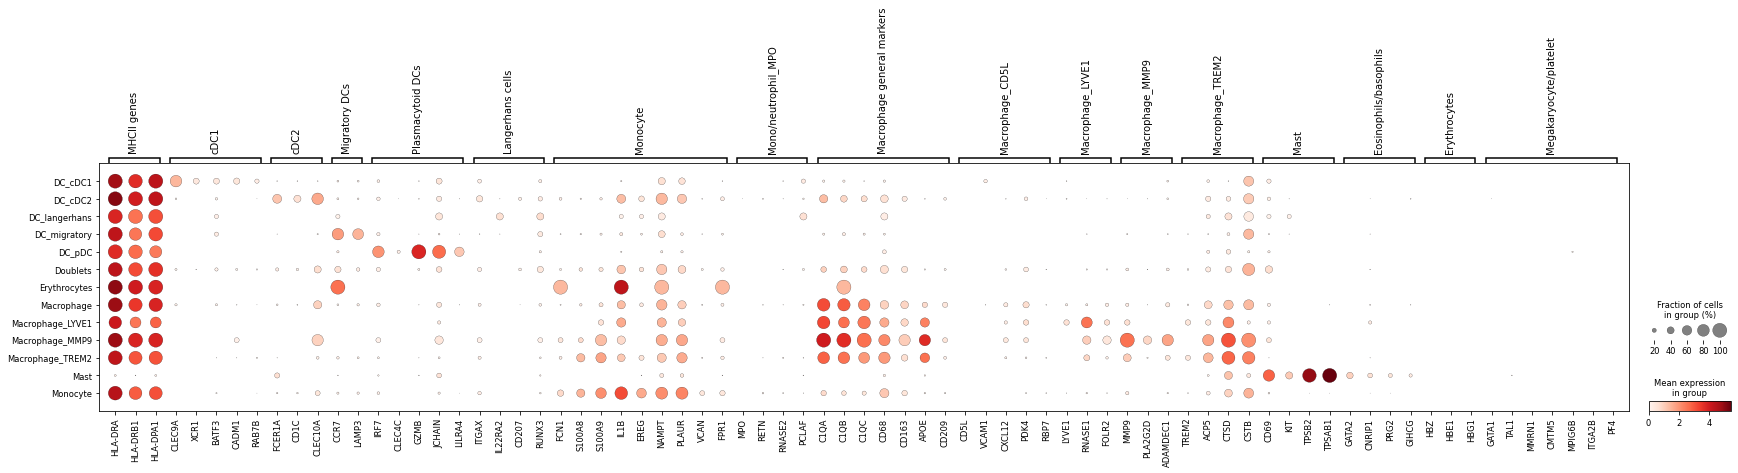

In [27]:
#cross reference marker genes
marker_genes_dict = {'MHCII genes':['HLA-DRA','HLA-DRB1','HLA-DPA1'],
                     'cDC1':['CLEC9A','XCR1','BATF3','CADM1','RAB7B'],
                    'cDC2':['FCER1A','CD1C','CLEC10A'],
                    'Migratory DCs':['CCR7','LAMP3'],
                    'Plasmacytoid DCs':['IRF7','CLEC4C','GZMB','JCHAIN','LILRA4'],
                     'Langerhans cells':['ITGAX','IL22RA2','CD207','RUNX3'],
                    'Monocyte':['FCN1','S100A8','S100A9','IL1B','EREG','NAMPT','PLAUR','VCAN','FPR1'],
                     'Mono/neutrophil_MPO':['MPO','RETN','RNASE2','PCLAF'],
                    'Macrophage general markers':['C1QA','C1QB','C1QC','CD68','CD163','APOE','CD209'],
                    'Macrophage_CD5L':['CD5L','VCAM1','CXCL12','PDK4','RBP7'],
                    'Macrophage_LYVE1':['LYVE1','RNASE1','FOLR2'],
                    'Macrophage_MMP9':['MMP9','PLA2G2D','ADAMDEC1'],
                    'Macrophage_TREM2':['TREM2','ACP5','CTSD','CSTB'],
                    'Mast':['CD69','KIT','TPSB2','TPSAB1'],
                     'Eosinophils/basophils':['GATA2','CNRIP1','PRG2','GIHCG'],
                    'Erythrocytes':['HBZ','HBE1','HBG1'],
                    'Megakaryocyte/platelet':['GATA1','TAL1','MMRN1','CMTM5','MPIG6B','ITGA2B','PF4']
                    }
sc.pp.normalize_total(subset, target_sum=1e4)
sc.pp.log1p(subset)
sc.pl.dotplot(subset,var_names=marker_genes_dict,groupby='predicted_level_3_annot',use_raw=False)

## Neural cells

INFO     File /home/jupyter/Atlas_test/models/scANVI_models/Neural_scanvi_fine_annot.20230226
         /model.pt already downloaded                                                        
INFO     Training for 100 epochs.                                                            


/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/data/_utils.py:156: UserWarning: Category 83 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_scanvi.py:89: UserWarning: Missing labels key fine_annot. Filling in with unlabeled category Unknown.
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
            

Epoch 100/100: 100%|██████████| 100/100 [00:02<00:00, 49.06it/s, loss=750, v_num=1]
finished!


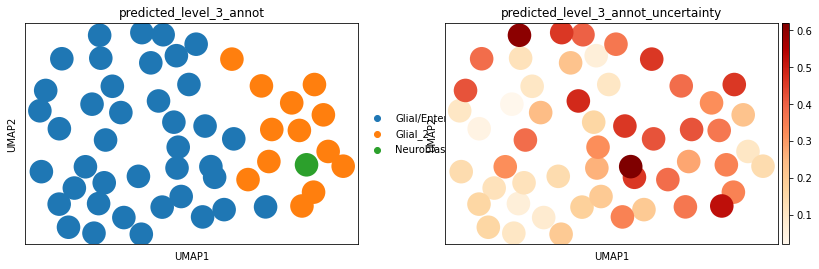

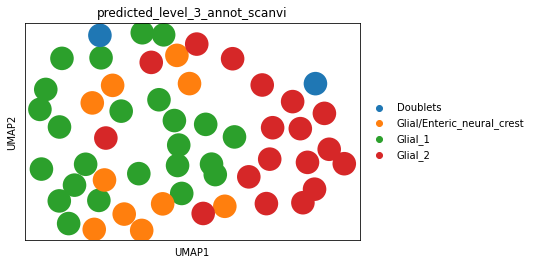

In [28]:
subset = neural
subset_name = "Neural"
scanvi_model = "Neural_scanvi_fine_annot.20230226"
knn_model = "knn_label_transfer_model_healthy_reference_Neural_20230226.pkl"
ref_obs_path = "/home/jupyter/Annotations_v3/meta/obs_for_knn/"

#set subset as bdata
bdata = subset.copy()

#run scANVI
scanvi_query = scvi.model.SCANVI.load_query_data(
    bdata,
    scanvi_models_path+scanvi_model, 
    inplace_subset_query_vars = True
)
scanvi_query.train(
    max_epochs=100, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10
)
bdata.obsm["X_scANVI"] = scanvi_query.get_latent_representation()
#if desired, save latent coordinates as dataframe eg.
#pd.DataFrame(
#    adata.obsm["X_scANVI"],
#    index=adata.obs_names,
#    columns=[f"LV{i+1}" for i in range(disease_ad.obsm["X_scANVI"].shape[1])],
#).to_csv(
#    "/path/scANVI_obsm.csv"
#)


#load k_neighbors_transformer
with open(knn_models_path+knn_model, 'rb') as f:
    k_neighbors_transformer = pickle.load(f)

#load reference obs
ref_obs = pd.read_csv(knn_models_path+'obs/'+subset_name+'_obs.csv')
    
#run KNN
labels, uncert = weighted_knn_transfer(
        query_adata=bdata,
        query_adata_emb="X_scANVI",
        label_keys="fine_annot",
        knn_model=k_neighbors_transformer,
        ref_adata_obs = ref_obs
    )

#weighted knn transfer prediction
bdata.obs['predicted_level_3_annot'] = labels['fine_annot']
bdata.obs['predicted_level_3_annot_uncertainty'] = uncert['fine_annot']
#scanvi prediction
bdata.obs["predicted_level_3_annot_scanvi"] = scanvi_query.predict(bdata)

#now lets visualise the data
sc.pp.neighbors(bdata, use_rep="X_scANVI")
sc.tl.umap(bdata)
sc.pl.umap(bdata, color=['predicted_level_3_annot','predicted_level_3_annot_uncertainty'], color_map="OrRd")
sc.pl.umap(bdata, color=['predicted_level_3_annot_scanvi'], color_map="OrRd")

#save object
subset.obs['predicted_level_3_annot'] = bdata.obs['predicted_level_3_annot']
subset.obs['predicted_level_3_annot_scanvi'] = bdata.obs['predicted_level_3_annot_scanvi']
subset.obs['predicted_level_1_annot_uncertainty'] = bdata.obs['predicted_level_1_annot_uncertainty'].astype(float)
subset.obs['predicted_level_3_annot_uncertainty'] = bdata.obs['predicted_level_3_annot_uncertainty'].astype(float)
subset.write("/home/jupyter/Atlas_test/output/"+subset_name+"_level_3_annotations.h5ad")
#and/or save metadata and latent coordinates
#pd.DataFrame(
#    bdata.obsm["X_scANVI"],
#    index=bdata.obs_names,
#    columns=[f"LV{i+1}" for i in range(bdata.obsm["X_scANVI"].shape[1])],
#).to_csv(
#    "/path/scANVI_obsm.csv"
#)
obs_to_save = bdata.obs[['predicted_level_3_annot','predicted_level_3_annot_uncertainty','predicted_level_3_annot_scanvi']]
obs_to_save.to_csv('/home/jupyter/Atlas_test/output/'+subset_name+'level_3_pred.csv')

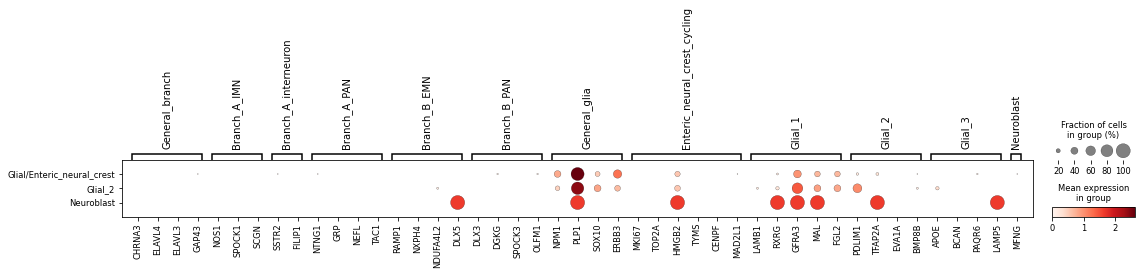

In [29]:
#cross reference marker genes
marker_genes_dict = {'General_branch':['CHRNA3','ELAVL4','ELAVL3','GAP43'],
                    'Branch_A_IMN':['NOS1','SPOCK1','SCGN'],
                     'Branch_A_interneuron':['SSTR2','FILIP1'],
                     'Branch_A_PAN':['NTNG1','GRP','NEFL','TAC1'],
                     'Branch_B_EMN':['RAMP1','NXPH4','NDUFA4L2','DLX5'],
                     'Branch_B_PAN':['DLX3','DGKG','SPOCK3','OLFM1'],
                     'General_glia':['NPM1','PLP1','SOX10','ERBB3'],
                     'Enteric_neural_crest_cycling':['MKI67','TOP2A','HMGB2','TYMS','CENPF','MAD2L1'],
                     'Glial_1':['LAMB1','RXRG','GFRA3','MAL','FGL2'],
                     'Glial_2':['PDLIM1','TFAP2A','EVA1A','BMP8B'],
                     'Glial_3':['APOE','BCAN','PAQR6','LAMP5'],
                     'Neuroblast':['MFNG']
                    }
sc.pp.normalize_total(subset, target_sum=1e4)
sc.pp.log1p(subset)
sc.pl.dotplot(subset,var_names=marker_genes_dict,groupby='predicted_level_3_annot',use_raw=False)

## T and NK cells

INFO     File /home/jupyter/Atlas_test/models/scANVI_models/TNK_scanvi_fine_annot.20230226/mo
         del.pt already downloaded                                                           
INFO     Training for 100 epochs.                                                            


/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_scanvi.py:89: UserWarning: Missing labels key fine_annot. Filling in with unlabeled category Unknown.
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
               

Epoch 100/100: 100%|██████████| 100/100 [00:49<00:00,  2.04it/s, loss=517, v_num=1]
finished!


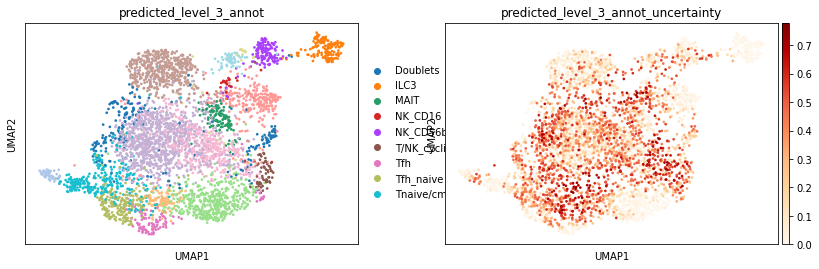

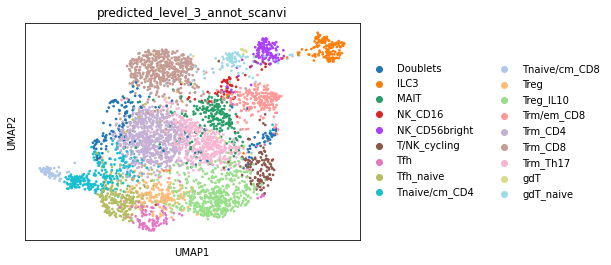

In [30]:
subset = tnk
subset_name = "TNK"
scanvi_model = "TNK_scanvi_fine_annot.20230226"
knn_model = "knn_label_transfer_model_healthy_reference_TNK_20230226.pkl"
ref_obs_path = "/home/jupyter/Annotations_v3/meta/obs_for_knn/"

#set subset as bdata
bdata = subset.copy()

#run scANVI
scanvi_query = scvi.model.SCANVI.load_query_data(
    bdata,
    scanvi_models_path+scanvi_model, 
    inplace_subset_query_vars = True
)
scanvi_query.train(
    max_epochs=100, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10
)
bdata.obsm["X_scANVI"] = scanvi_query.get_latent_representation()
#if desired, save latent coordinates as dataframe eg.
#pd.DataFrame(
#    adata.obsm["X_scANVI"],
#    index=adata.obs_names,
#    columns=[f"LV{i+1}" for i in range(disease_ad.obsm["X_scANVI"].shape[1])],
#).to_csv(
#    "/path/scANVI_obsm.csv"
#)


#load k_neighbors_transformer
with open(knn_models_path+knn_model, 'rb') as f:
    k_neighbors_transformer = pickle.load(f)

#load reference obs
ref_obs = pd.read_csv(knn_models_path+'obs/'+subset_name+'_obs.csv')
    
#run KNN
labels, uncert = weighted_knn_transfer(
        query_adata=bdata,
        query_adata_emb="X_scANVI",
        label_keys="fine_annot",
        knn_model=k_neighbors_transformer,
        ref_adata_obs = ref_obs
    )

#weighted knn transfer prediction
bdata.obs['predicted_level_3_annot'] = labels['fine_annot']
bdata.obs['predicted_level_3_annot_uncertainty'] = uncert['fine_annot']
#scanvi prediction
bdata.obs["predicted_level_3_annot_scanvi"] = scanvi_query.predict(bdata)

#now lets visualise the data
sc.pp.neighbors(bdata, use_rep="X_scANVI")
sc.tl.umap(bdata)
sc.pl.umap(bdata, color=['predicted_level_3_annot','predicted_level_3_annot_uncertainty'], color_map="OrRd")
sc.pl.umap(bdata, color=['predicted_level_3_annot_scanvi'], color_map="OrRd")

#save object
subset.obs['predicted_level_3_annot'] = bdata.obs['predicted_level_3_annot']
subset.obs['predicted_level_3_annot_scanvi'] = bdata.obs['predicted_level_3_annot_scanvi']
subset.obs['predicted_level_1_annot_uncertainty'] = bdata.obs['predicted_level_1_annot_uncertainty'].astype(float)
subset.obs['predicted_level_3_annot_uncertainty'] = bdata.obs['predicted_level_3_annot_uncertainty'].astype(float)
subset.write("/home/jupyter/Atlas_test/output/"+subset_name+"_level_3_annotations.h5ad")
#and/or save metadata and latent coordinates
#pd.DataFrame(
#    bdata.obsm["X_scANVI"],
#    index=bdata.obs_names,
#    columns=[f"LV{i+1}" for i in range(bdata.obsm["X_scANVI"].shape[1])],
#).to_csv(
#    "/path/scANVI_obsm.csv"
#)
obs_to_save = bdata.obs[['predicted_level_3_annot','predicted_level_3_annot_uncertainty','predicted_level_3_annot_scanvi']]
obs_to_save.to_csv('/home/jupyter/Atlas_test/output/'+subset_name+'level_3_pred.csv')

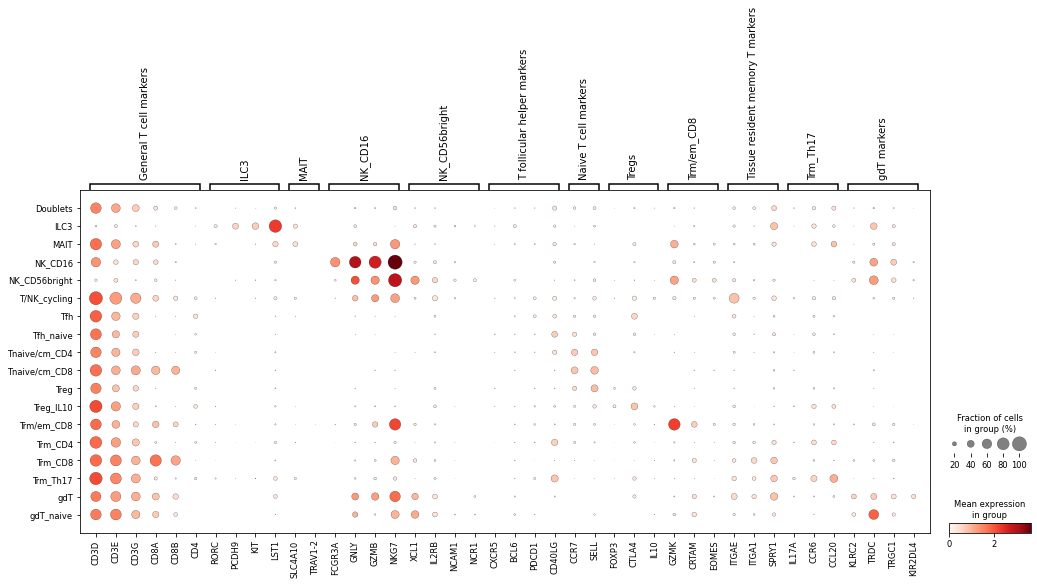

In [31]:
#cross reference marker genes
marker_genes_dict = {'General T cell markers': ['CD3D','CD3E','CD3G','CD8A','CD8B','CD4'],
                     'ILC3': ['RORC','PCDH9','KIT','LST1'],
                     'MAIT': ['SLC4A10','TRAV1-2'],
                     'NK_CD16': ['FCGR3A','GNLY','GZMB','NKG7'],
                     'NK_CD56bright': ['XCL1','IL2RB','NCAM1','NCR1'],
                     'T follicular helper markers':['CXCR5','BCL6','PDCD1','CD40LG'],
                     'Naive T cell markers': ['CCR7','SELL'],
                     'Tregs': ['FOXP3','CTLA4','IL10'],
                    'Trm/em_CD8':['GZMK','CRTAM','EOMES'],
                    'Tissue resident memory T markers':['ITGAE','ITGA1','SPRY1'],
                    'Trm_Th17':['IL17A','CCR6','CCL20'],
                    'gdT markers':['KLRC2','TRDC','TRGC1','KIR2DL4']
                    }
sc.pp.normalize_total(subset, target_sum=1e4)
sc.pp.log1p(subset)
sc.pl.dotplot(subset,var_names=marker_genes_dict,groupby='predicted_level_3_annot',use_raw=False)

## Epithelial cells

INFO     File /home/jupyter/Atlas_test/models/scANVI_models/Epi/SI_AP_epi_scanvi_fine_annot.u
         pdated20240131/model.pt already downloaded                                          
INFO     Training for 100 epochs.                                                            


/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/data/_utils.py:156: UserWarning: Category 26 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_scanvi.py:89: UserWarning: Missing labels key fine_annot. Filling in with unlabeled category Unknown.
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
            

Epoch 100/100: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s, loss=951, v_num=1]
finished!


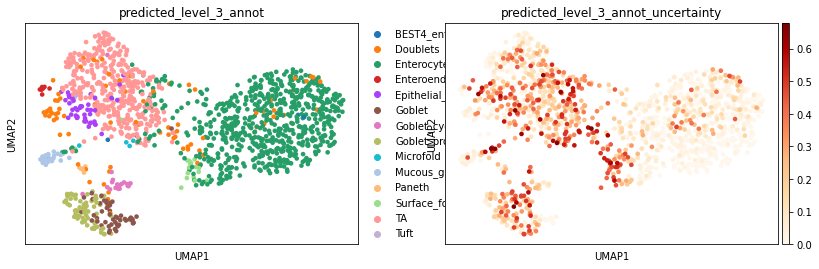

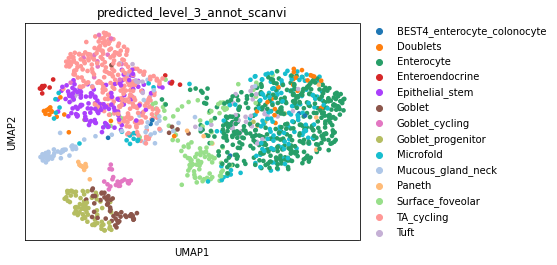

In [32]:
subset = epi
subset_name = "Epi_SI_AP"
scanvi_model = "Epi/SI_AP_epi_scanvi_fine_annot.updated20240131"
knn_model = "knn_label_transfer_model_healthy_reference_Epi_SI_AP_20241005.pkl"
ref_obs_path = "/home/jupyter/Annotations_v3/meta/obs_for_knn/"

#set subset as bdata
bdata = subset.copy()

#run scANVI
scanvi_query = scvi.model.SCANVI.load_query_data(
    bdata,
    scanvi_models_path+scanvi_model, 
    inplace_subset_query_vars = True
)
scanvi_query.train(
    max_epochs=100, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10
)
bdata.obsm["X_scANVI"] = scanvi_query.get_latent_representation()
#if desired, save latent coordinates as dataframe eg.
#pd.DataFrame(
#    adata.obsm["X_scANVI"],
#    index=adata.obs_names,
#    columns=[f"LV{i+1}" for i in range(disease_ad.obsm["X_scANVI"].shape[1])],
#).to_csv(
#    "/path/scANVI_obsm.csv"
#)


#load k_neighbors_transformer
with open(knn_models_path+knn_model, 'rb') as f:
    k_neighbors_transformer = pickle.load(f)

#load reference obs
ref_obs = pd.read_csv(knn_models_path+'obs/'+subset_name+'_obs.csv')
    
#run KNN
labels, uncert = weighted_knn_transfer(
        query_adata=bdata,
        query_adata_emb="X_scANVI",
        label_keys="fine_annot",
        knn_model=k_neighbors_transformer,
        ref_adata_obs = ref_obs
    )

#weighted knn transfer prediction
bdata.obs['predicted_level_3_annot'] = labels['fine_annot']
bdata.obs['predicted_level_3_annot_uncertainty'] = uncert['fine_annot']
#scanvi prediction
bdata.obs["predicted_level_3_annot_scanvi"] = scanvi_query.predict(bdata)

#now lets visualise the data
sc.pp.neighbors(bdata, use_rep="X_scANVI")
sc.tl.umap(bdata)
sc.pl.umap(bdata, color=['predicted_level_3_annot','predicted_level_3_annot_uncertainty'], color_map="OrRd")
sc.pl.umap(bdata, color=['predicted_level_3_annot_scanvi'], color_map="OrRd")

#save object
subset.obs['predicted_level_3_annot'] = bdata.obs['predicted_level_3_annot']
subset.obs['predicted_level_3_annot_scanvi'] = bdata.obs['predicted_level_3_annot_scanvi']
subset.obs['predicted_level_1_annot_uncertainty'] = bdata.obs['predicted_level_1_annot_uncertainty'].astype(float)
subset.obs['predicted_level_3_annot_uncertainty'] = bdata.obs['predicted_level_3_annot_uncertainty'].astype(float)
subset.write("/home/jupyter/Atlas_test/output/"+subset_name+"_level_3_annotations.h5ad")
#and/or save metadata and latent coordinates
#pd.DataFrame(
#    bdata.obsm["X_scANVI"],
#    index=bdata.obs_names,
#    columns=[f"LV{i+1}" for i in range(bdata.obsm["X_scANVI"].shape[1])],
#).to_csv(
#    "/path/scANVI_obsm.csv"
#)
obs_to_save = bdata.obs[['predicted_level_3_annot','predicted_level_3_annot_uncertainty','predicted_level_3_annot_scanvi']]
obs_to_save.to_csv('/home/jupyter/Atlas_test/output/'+subset_name+'level_3_pred.csv')

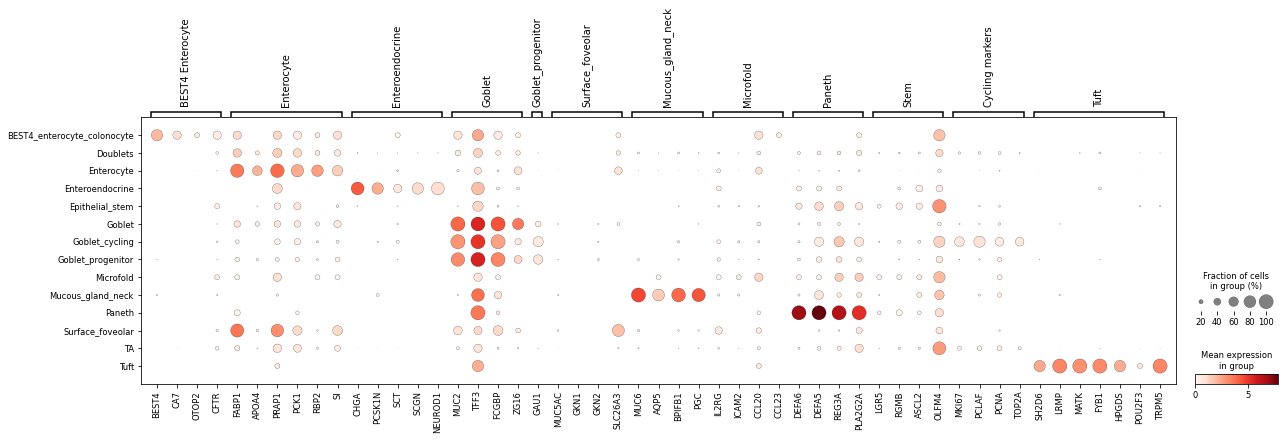

In [33]:
#cross reference marker genes
marker_genes_dict = {'BEST4 Enterocyte':['BEST4','CA7','OTOP2','CFTR'],
                    'Enterocyte':['FABP1','APOA4','PRAP1','PCK1','RBP2','SI'],
                     'Enteroendocrine':['CHGA','PCSK1N','SCT','SCGN','NEUROD1'],
                     'Goblet':['MUC2','TFF3','FCGBP','ZG16'],
                      'Goblet_progenitor':['GAU1'],
                     'Surface_foveolar':['MUC5AC','GKN1','GKN2','SLC26A3'],
                     'Mucous_gland_neck':['MUC6','AQP5','BPIFB1','PGC'],
                     'Microfold':['IL2RG','ICAM2','CCL20','CCL23'],
                     'Paneth':['DEFA6','DEFA5','REG3A','PLA2G2A'],
                     'Stem':['LGR5','RGMB','ASCL2','OLFM4'],
                     'Cycling markers':['MKI67','PCLAF','PCNA','TOP2A'],
                     'Tuft':['SH2D6','LRMP','MATK','FYB1','HPGDS','POU2F3', 'TRPM5']
                     }
sc.pp.normalize_total(subset, target_sum=1e4)
sc.pp.log1p(subset)
sc.pl.dotplot(subset,var_names=marker_genes_dict,groupby='predicted_level_3_annot',use_raw=False)

__A note on finalising annotations:__
As the results above show, the uncertainty score can be much higher for fine grained annotations which is to be expected when annotating cells in more detail. Our recommendation is to cross reference annotations with marker genes and particularly examine marker genes in cells with high level of uncertainty. For the atlas disease annotations, we took cells in the 90th percentile uncertainty score, performed leiden clustering and then assigned final labels based on majority voting within the clusters. We would also recommend to use our celltypist model(s) to give further confidence on annotations. 

#### Marker genes of other subsets
Useful for running this code on your own dataset if they contain samples from other regions/ages than this test dataset